In [19]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(train.head())

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
print(train.head())


   id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     

In [21]:
y = train['price']
del train['price']

print(train.columns)

del train['id']

print(train.columns)

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


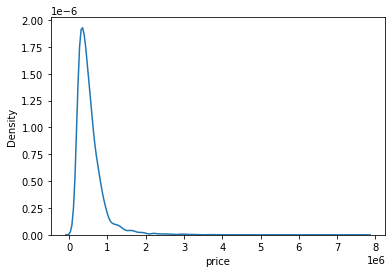

In [22]:
sns.kdeplot(y)
plt.show()


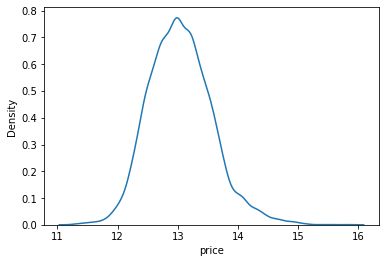

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [23]:
y = np.log1p(y)


sns.kdeplot(y)
plt.show()

train.info()

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=1

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [25]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)


,RMSE
GradientBoostingRegressor,131579.080390
RandomForestRegressor,130081.013501
XGBRegressor,115479.923811
LGBMRegressor,111388.404203


In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)


def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    results.plot()
    
    print('최적 매개변수 점수 ==> {:.3f}'.format(grid_model.best_score_))
    print('최적 매개변수 ==> {}'.format(grid_model.best_params_))
    #print('최적 매개변수의 테스트 점수 ==> {:.3f}'.format(grid_model.score(x_test, y_test)))
    

    return results

Fitting 5 folds for each of 4 candidates, totalling 20 fits
최적 매개변수 점수 ==> -0.027
최적 매개변수 ==> {'max_depth': 10, 'n_estimators': 100}


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


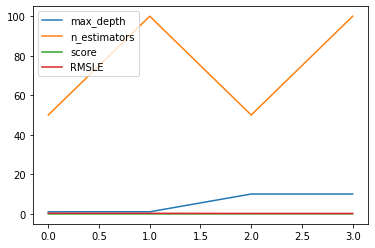

In [27]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=1, n_jobs=5)

In [28]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)


def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))
    
# save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

튜닝해볼 수 있는 모델 클래스 인자
:
max_depth
learning_rate
n_estimators
num_leaves
boosting_type

그 전에 시각화 가설을 세워보자

1. 히트맵
2. 분포도

0.5
[2, 4]
[1, 0.1]
0


In [74]:
# gridsearch 범위를 손쉽게 제어하기 위한 코드
# gridsearch 범위를 range 값으로 제어 가능
# p 값을 조정해서 범위 제어 가능

p = 0.7

max_depth = []
for i in list(range(int(5*p))): max_depth.append((1+i)*2)

learning_rate = []
for i in list(range(int(5*p))):
        for j in range(i):
            i*10
        learning_rate.append(10**-i)

n_estimators = []
for i in list(range(int(10*p))): n_estimators.append(i*10)

num_leaves = list(range(int(5*p)))
# for i in list(range(10)): num_leaves.append(i)

boosting_type = ['gbdt', 'rf']

min_smaples_leaf = []
for i in list(range(int(5*p))): min_smaples_leaf.append(i*10)

min_samples_split = []
for i in list(range(int(5*p))): min_samples_split.append(i*10)


print(max_depth)
print(learning_rate)
print(n_estimators)
print(num_leaves)
print(min_smaples_leaf)
print(min_samples_split)


print('경우의 수:', len(max_depth)*len(learning_rate)*len(n_estimators)*len(num_leaves)*len(min_samples_split)*len(min_smaples_leaf)*len(boosting_type))


[2, 4, 6]
[1, 0.1, 0.01]
[0, 10, 20, 30, 40, 50, 60]
[0, 1, 2]
[0, 10, 20]
[0, 10, 20]
경우의 수: 3402


Fitting 5 folds for each of 1701 candidates, totalling 8505 fits
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=20, min_sm

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=0, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=0, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=0, n_estimators=40, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=0, n_estimators=40, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_ra

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=0, n_estimators=30, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=0, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning]

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warn

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learnin

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learnin

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=10, min_smaples_leaf=0, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=10, min_smaples_leaf=0, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warn

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END lea

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=60, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=60, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=60, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END lea

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=0, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=0, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=0, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=0, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learnin

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END lea

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END lea

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=60, num_leaves=2; total time=   0.1s
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=2; total time=   0.

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END lea

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning]

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learnin

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learnin

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learnin

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=60, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learnin

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learnin

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END lea

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=60, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [War

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=50, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learnin

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END lea

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=40, num_leaves=2; total time=   0.1s
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=0; total time=   0

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=20, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=20, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=20, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=4, min_samples_split=20, min_smaples_leaf=20, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning]

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning]

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_ra

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warn

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warn

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learnin

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=0, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=30, num_leaves=2; total time=   0.1s
[L

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learnin

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END lea

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=40, num_leaves=1; total time=   0.0s
[LightGBM] [

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=20, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warn

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warn

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=0, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=0, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=0, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=0, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END lea

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGB

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=50, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=50, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=50, num_leaves=1; total time=   0.0s
[LightGB

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=0, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=0, n_estimators=60, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, m

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_sm

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=40, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=40, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=40, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=40, num_leaves=2; total time=   0.1s
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=50, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=50, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=50, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=50, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV]

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=0, n_estimators=60, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=0, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=0, n_estimators=60, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, min_sa

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=0, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=0, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=0, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=0, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=0, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] 

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=40, num_leaves=2; total time=   0.1s
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=50, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=50, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=50, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=50, num_leaves=1; total time=   0.0s
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV]

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=40, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=40, num_leaves=1; total time=   0.0s
[LightGBM] [

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=30, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGB

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGB

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=40, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGB

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=60, num_leaves=2; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total ti

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=2; total time=   0.0s
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGB

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV]

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata


[CV] END learning_rate=0.1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END lea

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=40, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=40, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGB

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=60, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_l

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=60, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=60, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=60, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=0; total time=   0.0s
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=20, num_leaves=2; total time=   0.1s
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=0, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END 

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=30, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=30, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_sm

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=40, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata


[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.1, max_depth=6, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV]

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=0, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_sa

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=50, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=0, min_smaples_leaf=10, n_estimators=50, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=0, min_smaples_leaf=20, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV]

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=0, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=0, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=0, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=0, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=60, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=60, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=60, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=60, num_leaves=0; total time=   0.0s


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=10, min_smaples_leaf=10, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=0, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=0, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=10, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Un

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=2, min_samples_split=20, min_smaples_leaf=20, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_l

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=0, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV]

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=10, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV]

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=20, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=0, min_smaples_leaf=20, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV]

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=0, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=10, num_leaves=2; t

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=60, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=1

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=10, n_estimators=60, num_leaves=2; total time=   0.1s


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV]

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=10, min_smaples_leaf=20, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=40, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=50, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=0,

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=0, n_estimators=60, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=0; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=20, n_estimators=0, num_leaves=1; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=20, n_estimators=40, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=20, n_estimators=40, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=20, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=20, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=50, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=50, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=4, min_samples_split=20, min_smaples_leaf=10, n_estimators=50, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGB

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=30, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=0, num_leaves=2; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=0, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_sa

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=40, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=40, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=40, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=0, n_estimators=60, num_leaves=2; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=0, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] EN

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=50, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=50, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=10, n_estimators=50, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=20, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=0, min_smaples_leaf=20, n_estimators=60, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV]

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=0, num_leaves=2; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=20, num_leaves=2; total time=   0.1s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=30, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=50, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=10, n_estimators=50, num_leaves=0; total time=   0.0s


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=10, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=30, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=10, min_smaples_leaf=20, n_estimators=40, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=20, min_smaples_leaf=0, n_estimators=10, num_leaves=2; total time=   0.1s
[Lig

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=60, num_leaves=0; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=60, num_leaves=1; total time=   0.0s
[LightGBM] [Warning] Unknown parameter: min_smaples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[CV] END learning_rate=0.01, max_depth=6, min_samples_split=20, min_smaples_leaf=10, n_estimators=60, num_leaves=1; total time=   0.0s


,learning_rate,max_depth,min_samples_split,min_smaples_leaf,n_estimators,num_leaves,score,RMSLE
482,1.00,6,10,10,60,2,-0.043579,0.208756
125,1.00,2,10,20,60,2,-0.043579,0.208756
230,1.00,4,0,10,60,2,-0.043579,0.208756
146,1.00,2,20,0,60,2,-0.043579,0.208756
356,1.00,4,20,10,60,2,-0.043579,0.208756
...,...,...,...,...,...,...,...,...
1693,0.01,6,20,20,40,1,NaN,NaN
1695,0.01,6,20,20,50,0,NaN,NaN
1696,0.01,6,20,20,50,1,NaN,NaN
1698,0.01,6,20,20,60,0,NaN,NaN


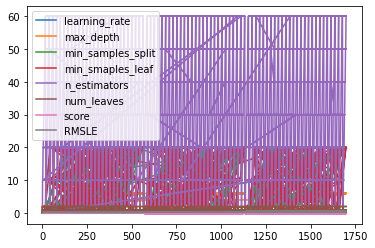

In [75]:

param_grid = {
    'max_depth': max_depth,
    'learning_rate': learning_rate,
    'n_estimators': n_estimators,
    'num_leaves': num_leaves,
    'min_smaples_leaf': min_smaples_leaf,
    'min_samples_split': min_samples_split
}

model = LGBMRegressor(random_state=random_state)

x_train, x_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

my_GridSearch(model, x_train, y_train, param_grid, verbose=2, n_jobs=-1)


In [77]:
df = {}

# 최적의 하이퍼 파라미터 입력

model = LGBMRegressor(learning_rate=1,max_depth=6,min_samples_split=10,min_samples_leaf=10,n_estimators=60,num_leaves=2,random_state=random_state)

x_train, x_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
df['LGB'] = rmse(y_test, y_pred)
score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)


# grid search가 너무 오래 걸려서 미리 짜놓은 코드
score_df
#score_df.plot.scatter()
#sns.heatmap(cor,annot=True ,cmap='YlGn')

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: min_samples_split


,RMSE
LGB,153433.263718


# 회고

과거 EX_1을 할 때 파라미터를 어떻게 제어해야 될지 몰라 오랫동안 헤맸었다
그러나 이번엔 gridsearchcv라는 하이퍼 파라미터를 자동으로 대입하고 최고점수를 낸 파라미터값을 출력해주는 기능을 배워 많이 기뻤다

허나 그것도 잠시
gridsearchcv의 범위를 어떻게 지정해야 될지 의문이 생겼다
최적의 값을 출력하는 하이퍼 파라미터 값을 내가 지정한 범위에서 나오지 않을 수 있지 않을까?
즉 최적의 하이퍼 파라미터 값을 찾으려면 엄청난 경우의 수를 대입해줘야 된다

하나의 파라미터 당 7개의 값을 대입한다 해도
7^6 = 117,649
어마어마한 수다

## 이번 프로젝트를 하며 느낀 점
처음에는 gridsearchCV가 나의 작업 속도를 줄여줄 아주 좋은 기능이라 생각했다
하지만 gridsearchCV가 계산하는데 걸리는 시간과
내가 과연 최적의 값을 gridsearchCV 범위 안에 넣었는가를 고민하다보니
"지금 내가 하는 행동이 인공지능이 학습하는 거랑 뭐가 다른 거지? 란 생각이 들었습니다"

그리고 최종적으로 든 생각이 하이퍼 파라미터를 막무가내로 대입해서는 답을 얻을 수 없다는 사실을 깨달았습니다

## 결론
gridsearchCV 로 최적의 값을 찾을 생각은 하지 말자
gridsearchCV 값을 근거로 최적의 값을 찾아주는 인공지능을 만든다면,
새로운 인공지능 모델을 만들어야 되고,
그 새로운 인공지능의 하이퍼 파라미터를 제어해줘야 되는데
또 그 값을 모른다고 gridsearchCV를 쓰고...

늪에 빠진다

In [ ]:
# 실패한 코드

"""

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


param_distributions = {
    'n_estimators': list(range(10)),
    'max_features':list(range(20)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(20)),
    'bootstrap':[True,False],
    'min_smaples_leaf':randint(1,4)
}

def rdSearch(model, train, y, n_iter=100):
    
    rd_search = RandomizedSearchCV(model, param_distributions=param_distributions, n_iter=n_iter, return_train_score=True)
    
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    results.plot

    return results


rdSearch(model, train, y, n_iter=100)

"""